# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [319]:
import lib.loadfunctions as lf 
import lib.analysisfunctions as af
import lib.plotfunctions as pf
import lib.savefunctions as svf
import lib.sanityfunctions as sanf
import lib.fieldtransformfunctions as ftf

import os
import math
import numpy as np

In [339]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(lf)
importlib.reload(af)
importlib.reload(pf)
importlib.reload(svf)
importlib.reload(sanf)
importlib.reload(ftf)

<module 'lib.fieldtransformfunctions' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/fieldtransformfunctions.py'>

### Load data

In [289]:
#variables related to loading
path = "M03/"
path_fields = "M03/"
path_particles = "M03/Output/Raw/Sp01/raw_sp01_{:08d}.h5"
numframe = 1000


In [5]:
#load fields
dfields = lf.field_loader(path=path_fields,num=numframe)

#load particle data
dparticles = lf.readParticlesPosandVelocityOnly(path_particles, numframe)

#load flow data
dflow = lf.flow_loader(path='run0/',num=1000)

ux (48, 48, 192)
uy (48, 48, 192)
uz (48, 48, 192)


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

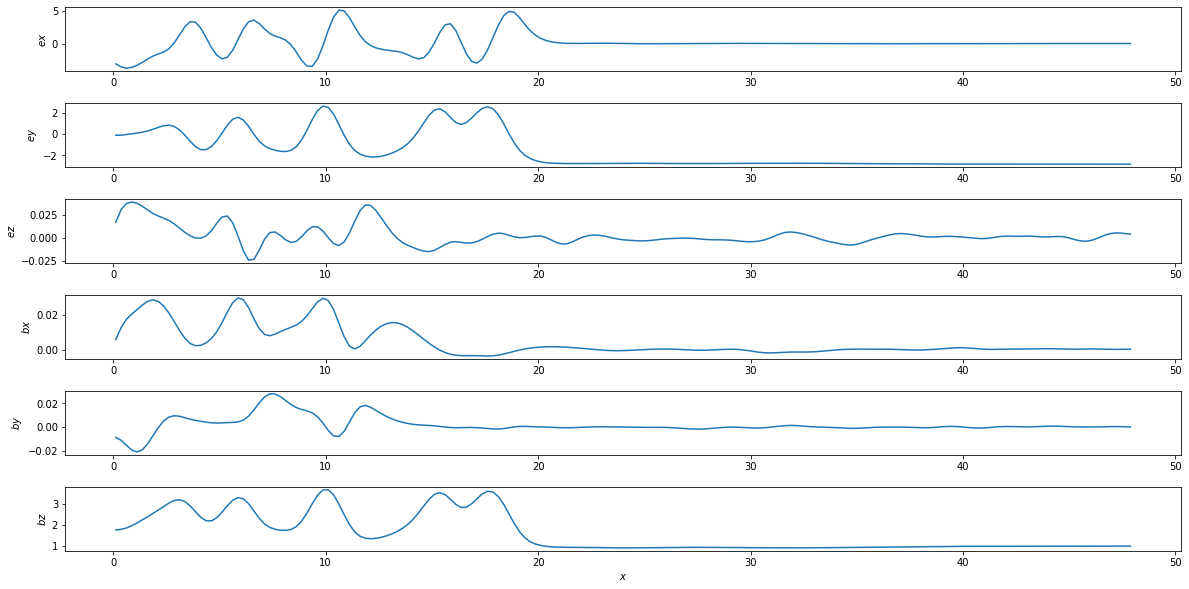

In [6]:
pf.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

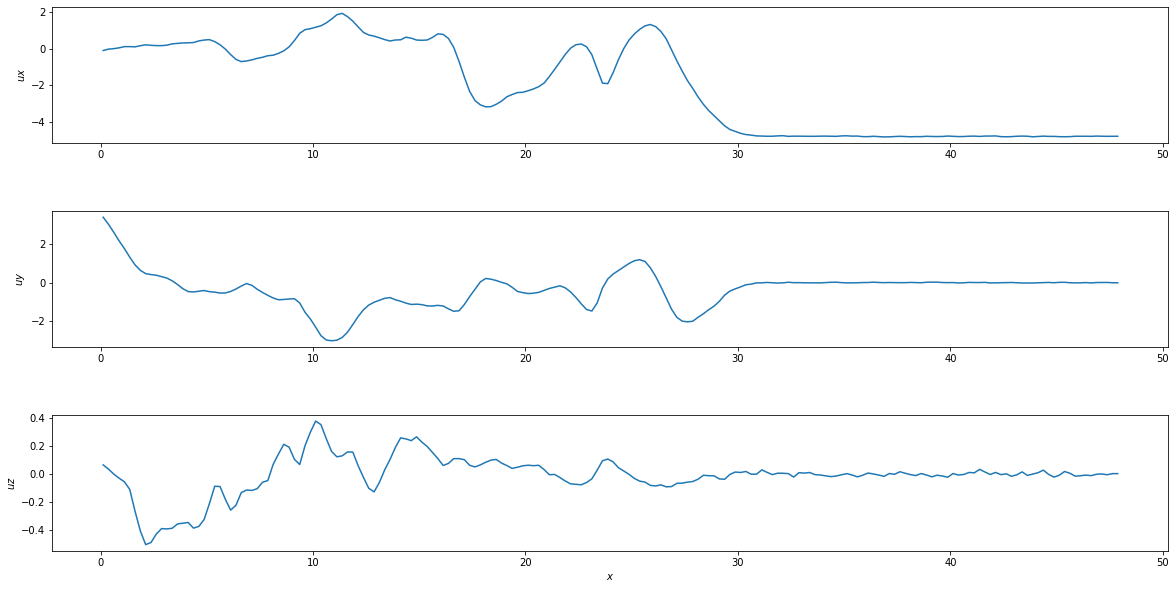

In [7]:
pf.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

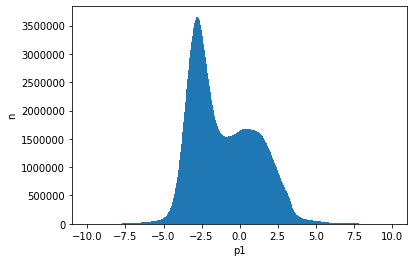

<Figure size 432x288 with 0 Axes>

In [8]:
pf.plot_1d_dist(dparticles, 'p1', 10., dfields['ex_xx'][0], dfields['ex_xx'][-1],dfields['ex_yy'][0], dfields['ex_yy'][-1])

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

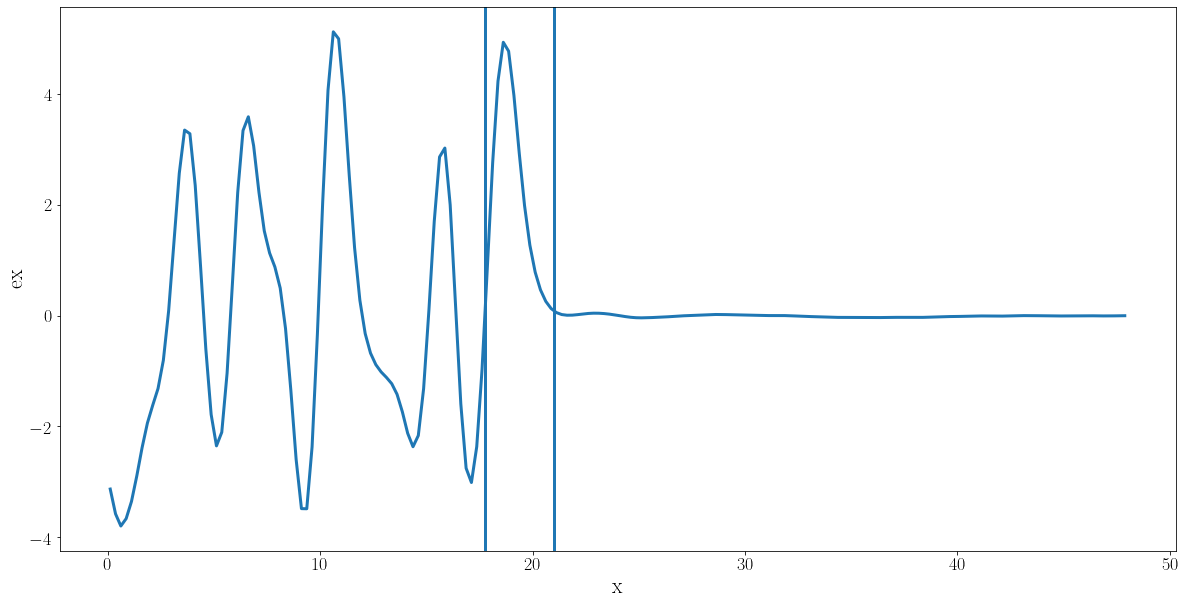

In [336]:
#Use this block to determine start and end val
startval = 17.75 #lower bound for metadata = 1 (di)
endval = 21. #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
pf.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [342]:
metadata = svf.build_metadata(dfields, startval, endval)

### Perform FPC analysis

In [343]:
#Define parameters related to analysis
vmax = 15.0
dv = 0.25
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0] #assumes rectangular grid thats uniform for all fields

In [121]:
CEx_out, CEy_out, x_out, Hxy_out, vx_out, vy_out = af.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx)

0.125 of 47.875
0.375 of 47.875
0.625 of 47.875
0.875 of 47.875
1.125 of 47.875
1.375 of 47.875
1.625 of 47.875
1.875 of 47.875
2.125 of 47.875
2.375 of 47.875
2.625 of 47.875
2.875 of 47.875
3.125 of 47.875
3.375 of 47.875
3.625 of 47.875
3.875 of 47.875
4.125 of 47.875
4.375 of 47.875
4.625 of 47.875
4.875 of 47.875
5.125 of 47.875
5.375 of 47.875
5.625 of 47.875
5.875 of 47.875
6.125 of 47.875
6.375 of 47.875
6.625 of 47.875
6.875 of 47.875
7.125 of 47.875
7.375 of 47.875
7.625 of 47.875
7.875 of 47.875
8.125 of 47.875
8.375 of 47.875
8.625 of 47.875
8.875 of 47.875
9.125 of 47.875
9.375 of 47.875
9.625 of 47.875
9.875 of 47.875
10.125 of 47.875
10.375 of 47.875
10.625 of 47.875
10.875 of 47.875
11.125 of 47.875
11.375 of 47.875
11.625 of 47.875
11.875 of 47.875
12.125 of 47.875
12.375 of 47.875
12.625 of 47.875
12.875 of 47.875
13.125 of 47.875
13.375 of 47.875
13.625 of 47.875
13.875 of 47.875
14.125 of 47.875
14.375 of 47.875
14.625 of 47.875
14.875 of 47.875
15.125 of 47.875
15.

### Calculate relevant simulation parameters and save as netcdf4

In [310]:
inputdict = svf.parse_input_file(path)

In [311]:
params = svf.build_params(inputdict,numframe)

In [315]:
flnm = 'dHybridRSDAtest1.nc'
try:
    svf.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, metadata_out = [], params = params, filename = flnm)
except:
    os.system('rm '+flnm)
    svf.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, metadata_out = [], params = params, filename = flnm)

Saving data into netcdf4 file


### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [316]:
CEx_in, CEy_in, vx_in, vy_in, x_in, metadata_in, params_in = svf.load_netcdf4(flnm)

### Make gif

In [13]:
pf.make_velsig_gif(vx, vy, vmax, CEx_out, 'ex', x_out, 'CExframe1000', 'CExframe1000.gif')

Making plot0 of 192
Making plot1 of 192
Making plot2 of 192
Making plot3 of 192
Making plot4 of 192
Making plot5 of 192
Making plot6 of 192
Making plot7 of 192
Making plot8 of 192
Making plot9 of 192
Making plot10 of 192
Making plot11 of 192
Making plot12 of 192
Making plot13 of 192
Making plot14 of 192
Making plot15 of 192
Making plot16 of 192
Making plot17 of 192
Making plot18 of 192
Making plot19 of 192
Making plot20 of 192
Making plot21 of 192
Making plot22 of 192
Making plot23 of 192
Making plot24 of 192
Making plot25 of 192
Making plot26 of 192
Making plot27 of 192
Making plot28 of 192
Making plot29 of 192
Making plot30 of 192
Making plot31 of 192
Making plot32 of 192
Making plot33 of 192
Making plot34 of 192
Making plot35 of 192
Making plot36 of 192
Making plot37 of 192
Making plot38 of 192
Making plot39 of 192
Making plot40 of 192
Making plot41 of 192
Making plot42 of 192
Making plot43 of 192
Making plot44 of 192
Making plot45 of 192
Making plot46 of 192
Making plot47 of 192
Ma

<img src="CExframe1000.gif" width="750" align="center">

In [15]:
pf.make_velsig_gif(vx, vy, vmax, CEy_out, 'ey', x_out, 'CEyframe1000', 'CEyframe1000.gif')

Making plot0 of 192
Making plot1 of 192
Making plot2 of 192
Making plot3 of 192
Making plot4 of 192
Making plot5 of 192
Making plot6 of 192
Making plot7 of 192
Making plot8 of 192
Making plot9 of 192
Making plot10 of 192
Making plot11 of 192
Making plot12 of 192
Making plot13 of 192
Making plot14 of 192
Making plot15 of 192
Making plot16 of 192
Making plot17 of 192
Making plot18 of 192
Making plot19 of 192
Making plot20 of 192
Making plot21 of 192
Making plot22 of 192
Making plot23 of 192
Making plot24 of 192
Making plot25 of 192
Making plot26 of 192
Making plot27 of 192
Making plot28 of 192
Making plot29 of 192
Making plot30 of 192
Making plot31 of 192
Making plot32 of 192
Making plot33 of 192
Making plot34 of 192
Making plot35 of 192
Making plot36 of 192
Making plot37 of 192
Making plot38 of 192
Making plot39 of 192
Making plot40 of 192
Making plot41 of 192
Making plot42 of 192
Making plot43 of 192
Making plot44 of 192
Making plot45 of 192
Making plot46 of 192
Making plot47 of 192
Ma

<img src="CEyframe1000.gif" width="750" align="center">

### Perform sanity checks
#### E cross B gif

In [35]:
pf.make_velsig_gif_with_EcrossB(vx, vy, vmax, CEx_out, 'ex', x_out, dx, dfields, 'CExFrame1000ExB', 'CExFrame1000ExB.gif')

Making plot 0 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 1 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 2 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 3 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 4 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 5 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 6 of 192
numgridpts sampled: 96
nu

numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 51 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 52 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 53 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 54 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 55 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 56 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sample

numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 102 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 103 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 104 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 105 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 106 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 107 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts 

numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 153 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 154 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 155 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 156 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 157 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 158 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts 

<img src="CExFrame1000ExB.gif" width="750" align="center">

In [36]:
pf.make_velsig_gif_with_EcrossB(vx, vy, vmax, CEy_out, 'ey', x_out, dx, dfields, 'CEyFrame1000ExB', 'CEyFrame1000ExB.gif')

Making plot 0 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 1 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 2 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 3 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 4 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 5 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 6 of 192
numgridpts sampled: 96
nu

numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 51 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 52 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 53 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 54 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 55 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 56 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sample

numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 102 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 103 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 104 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 105 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 106 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 107 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts 

numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 153 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 154 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 155 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 156 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 157 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
Making plot 158 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts 

<img src="CEyFrame1000ExB.gif" width="750" align="center">

#### Energization vs J dot E

0.0
0.25
0.5
0.75
1.0
1.25
1.5
1.75
2.0
2.25
2.5
2.75
3.0
3.25
3.5
3.75
4.0
4.25
4.5
4.75
5.0
5.25
5.5
5.75
6.0
6.25
6.5
6.75
7.0
7.25
7.5
7.75
8.0
8.25
8.5
8.75
9.0
9.25
9.5
9.75
10.0
10.25
10.5
10.75
11.0
11.25
11.5
11.75
12.0
12.25
12.5
12.75
13.0
13.25
13.5
13.75
14.0
14.25
14.5
14.75
15.0
15.25
15.5
15.75
16.0
16.25
16.5
16.75
17.0
17.25
17.5
17.75
18.0
18.25
18.5
18.75
19.0
19.25
19.5
19.75
20.0
20.25
20.5
20.75
21.0
21.25
21.5
21.75
22.0
22.25
22.5
22.75
23.0
23.25
23.5
23.75
24.0
24.25
24.5
24.75
25.0
25.25
25.5
25.75
26.0
26.25
26.5
26.75
27.0
27.25
27.5
27.75
28.0
28.25
28.5
28.75
29.0
29.25
29.5
29.75
30.0
30.25
30.5
30.75
31.0
31.25
31.5
31.75
32.0
32.25
32.5
32.75
33.0
33.25
33.5
33.75
34.0
34.25
34.5
34.75
35.0
35.25
35.5
35.75
36.0
36.25
36.5
36.75
37.0
37.25
37.5
37.75
38.0
38.25
38.5
38.75
39.0
39.25
39.5
39.75
40.0
40.25
40.5
40.75
41.0
41.25
41.5
41.75
42.0
42.25
42.5
42.75
43.0
43.25
43.5
43.75
44.0
44.25
44.5
44.75
45.0
45.25
45.5
45.75
46.0
46.25
46.5
46.75
47.0
4

findfont: Font family ["'sans-serif'"] not found. Falling back to DejaVu Sans.


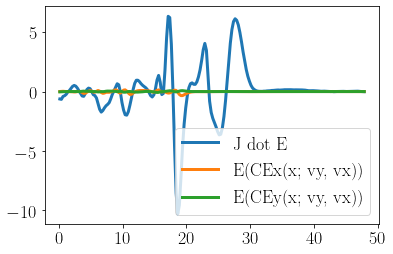

In [57]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1]))
    
    npar = sanf.getnumparticlesinbox(dparticles, xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1])
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


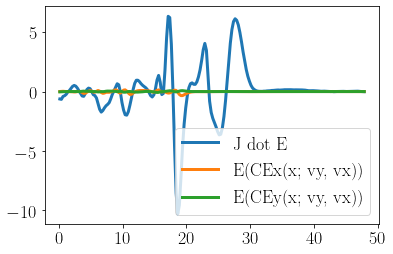

In [58]:
    
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

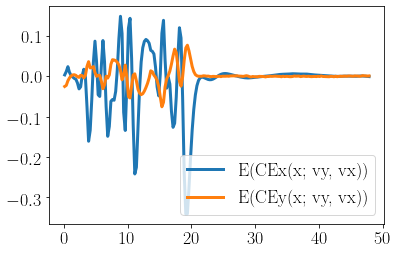

In [59]:
    
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()